In [1]:
from pathlib import Path
import pandas as pd
from typing import List, Tuple
import json
import matplotlib.pyplot as plt
import seaborn as sns
FIGSIZE = (13, 8)
DPI = 300
plt.style.use("ggplot")
# sns.set_palette("Set2")
PRECISION_KEY = "Precision_edit_dist"
RECALL_KEY = "Recall_edit_dist"
BETA = 0.25  # recall is beta times as important as precision
MAX_COVG = 0

# Combined callers SNPs only

In [2]:
coverages = {
    "mada_102": 150.0,
    "mada_104": 36.48,
    "mada_132": 29.44,
    "mada_116": 75.66,
    "mada_1-44": 126.66,
    "mada_130": 43.92,
    "mada_125": 63.69
}

def f1_score(precision: float, recall: float) -> float:
    return f_score(precision, recall, beta=1.0)

def f_score(precision: float, recall: float, beta: float = 1.0) -> float:
    """A more general F score, F beta, that uses a positive real factor beta, 
    where beta is chosen such that recall is considered beta times as 
    important as precision.
    Setting to 1 gives the f1 score
    Taken from https://en.wikipedia.org/wiki/F-score
    """
    b2 = beta**2
    return (1 + b2) * ((precision * recall) / ((b2 * precision) + recall))

def data_for_variants(directory: str) -> pd.DataFrame:
    json_files = list(Path(directory).rglob("*.json"))

    print(len(json_files))

    data: List[Tuple[str, str, str, float, float]] = []
    columns = ["prg", "sample", "tool", "precision", "recall", "false_negs", "coverage", "f1", "fbeta"]
    for p in json_files:
        d = json.loads(p.read_text())
        is_not_pandora = "compass" in p.parts[1] or "bcftools" in p.parts[1]
        prg = "none" if is_not_pandora else p.parts[2]
        if prg == "dense": continue
        sample = p.parts[2] if is_not_pandora else p.parts[3]
        tool = p.parts[1]
        covg = coverages[sample]
        if covg < MAX_COVG: continue
        if "FILT" in d["Precision"]:
            precision = float(d["Precision"]["FILT"][PRECISION_KEY])
            recall = float(d["Recall"]["FILT"][RECALL_KEY])
            fns = int(d["Recall"]["FILT"]["FN"]["Count"])
        else:
            precision = float(d["Precision"][PRECISION_KEY])
            recall = float(d["Recall"][RECALL_KEY])
            fns = int(d["Recall"]["FN"]["Count"])
        f1 = f1_score(precision, recall)
        fbeta = f_score(precision, recall, BETA)
        data.append((prg, sample, tool, precision, recall, fns, covg, f1, fbeta))
    return pd.DataFrame(data, columns=columns)

In [3]:
combined_df = data_for_variants("snps/")

378


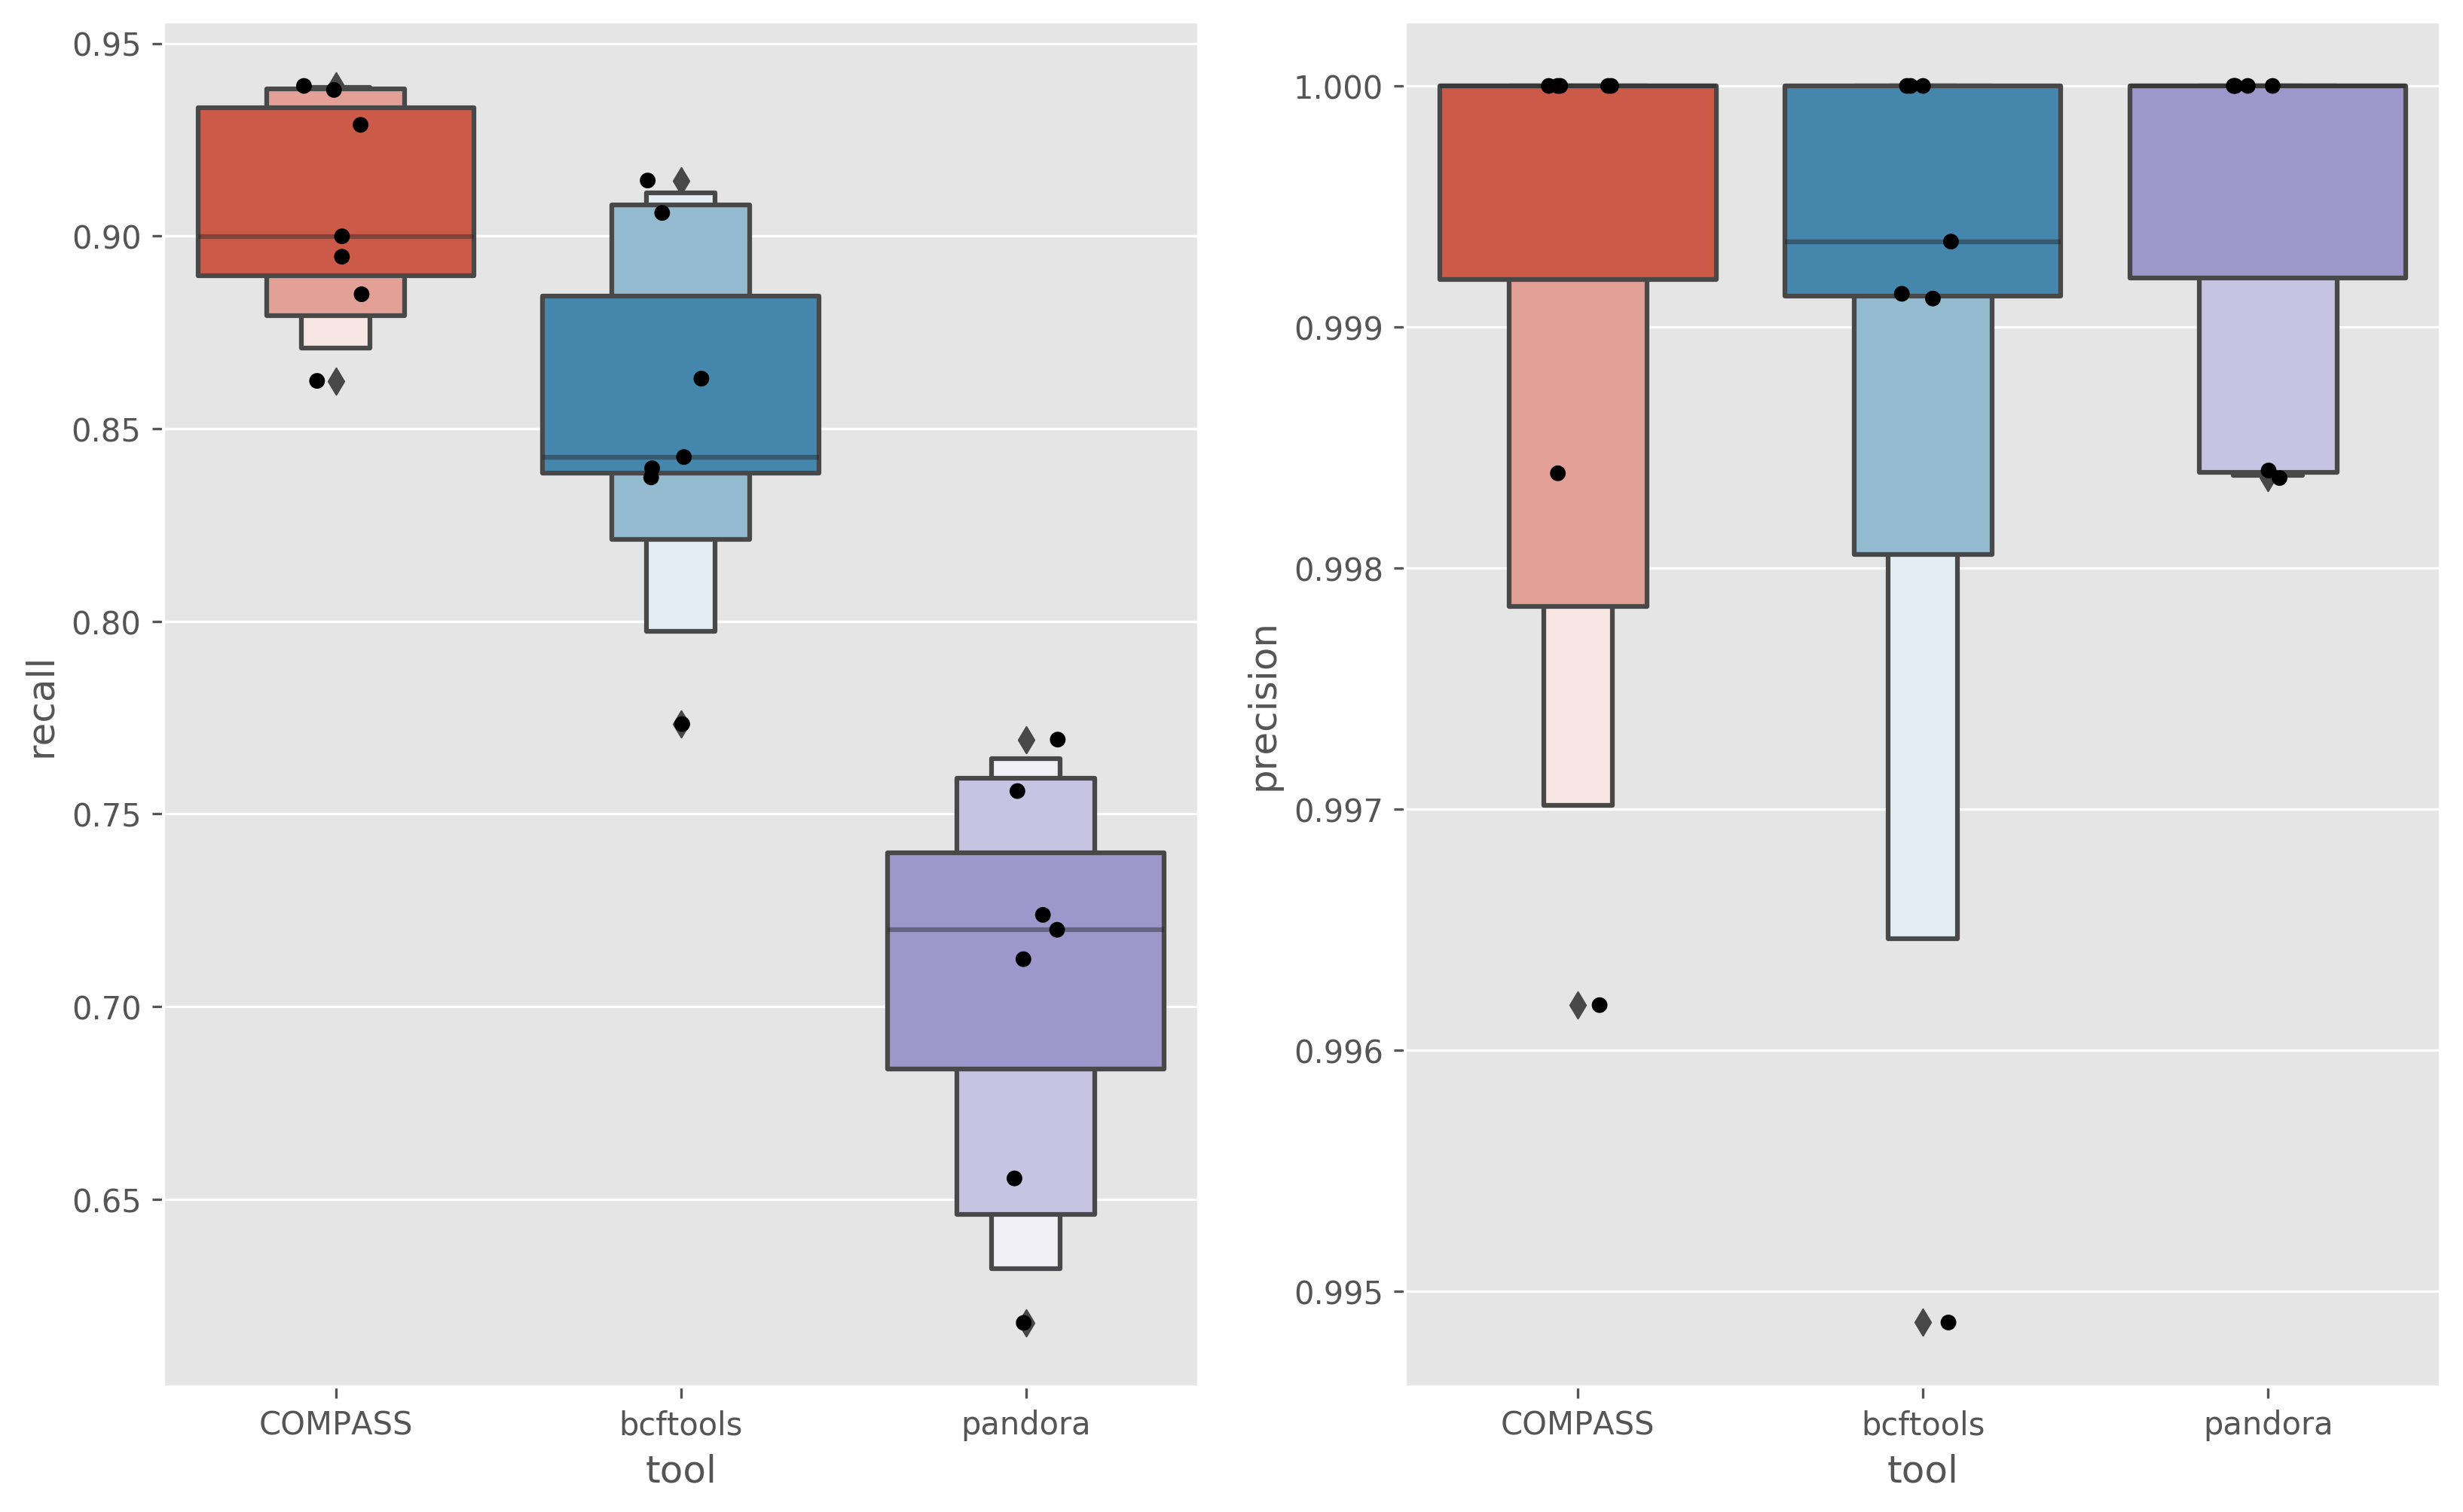

In [4]:
x = "tool"
y = "recall"
# hue = "prg"
df = combined_df.query("tool in ['compass', 'bcftools', 'd3s1g5K0.9'] and prg != 'dense'")
fixed_labels = ["compass", "bcftools", "d3s1g5K0.9"]
order = fixed_labels
fig, axes = plt.subplots(figsize=FIGSIZE, dpi=DPI, ncols=2)
ax = axes.flatten()[0]
sns.boxenplot(x=x, y=y, data=df, ax=ax, k_depth="full", order=order)
sns.stripplot(x=x, y=y, dodge=True, data=df, ax=ax, color="black", order=order)
# ax.set(title=f"{y.capitalize()} for different filters - SNPs only", xlabel="variant caller")
ax.set_ylabel("recall")
ax.set_xticklabels(["COMPASS", "bcftools", "pandora"])
# ax.set(ylim=(0.70, 0.95))
# plt.xticks(rotation=45)
# plt.legend(loc='lower left')
y = "precision"
# hue = "prg"
ax = axes.flatten()[1]
sns.boxenplot(x=x, y=y, data=df, ax=ax, k_depth="full", order=order)
sns.stripplot(x=x, y=y, dodge=True, data=df, ax=ax, color="black", order=order)
# ax.set(title=f"{y.capitalize()} for different filters - SNPs only", xlabel="variant caller")
ax.set_ylabel("precision")
_ = ax.set_xticklabels(["COMPASS", "bcftools", "pandora"])
# ax.set_ylim((0.996, 1.001))
# plt.xticks(rotation=45)
# plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)
# _ = ax.set_xticklabels(["compass", "bcftools", "#nofilter", "cluster-fix", "K0.9", "no-denovo"])

In [5]:
fig.savefig("/home/michael/Documents/phd/thesis/Chapter2/Figs/combined-precision-recall-filters-snps.png")

# Pandora filters SNPs only

In [6]:
include = {"compass", "none", "d3s1g5K0.9", "d3s1g5", "d3s1", "d3"}
directory = "snps/"
json_files = list(Path(directory).rglob("*.json"))

print(len(json_files))

data: List[Tuple[str, str, str, float, float]] = []
columns = ["prg", "sample", "tool", "precision", "recall", "false_negs", "coverage", "f1", "fbeta"]
for p in json_files:
    d = json.loads(p.read_text())
    is_not_pandora = "compass" in p.parts[1] or "bcftools" in p.parts[1]
    prg = "none" if is_not_pandora else p.parts[2]
    sample = p.parts[2] if is_not_pandora else p.parts[3]
    tool = p.parts[1]
    if tool not in include: continue
    covg = coverages[sample]
    if covg < MAX_COVG: continue
    if "FILT" in d["Precision"]:
        precision = float(d["Precision"]["FILT"][PRECISION_KEY])
        recall = float(d["Recall"]["FILT"][RECALL_KEY])
        fns = int(d["Recall"]["FILT"]["FN"]["Count"])
    else:
        precision = float(d["Precision"][PRECISION_KEY])
        recall = float(d["Recall"][RECALL_KEY])
        fns = int(d["Recall"]["FN"]["Count"])
    f1 = f1_score(precision, recall)
    fbeta = f_score(precision, recall, BETA)
    data.append((prg, sample, tool, precision, recall, fns, covg, f1, fbeta))
snps_df = pd.DataFrame(data, columns=columns)
# df

378


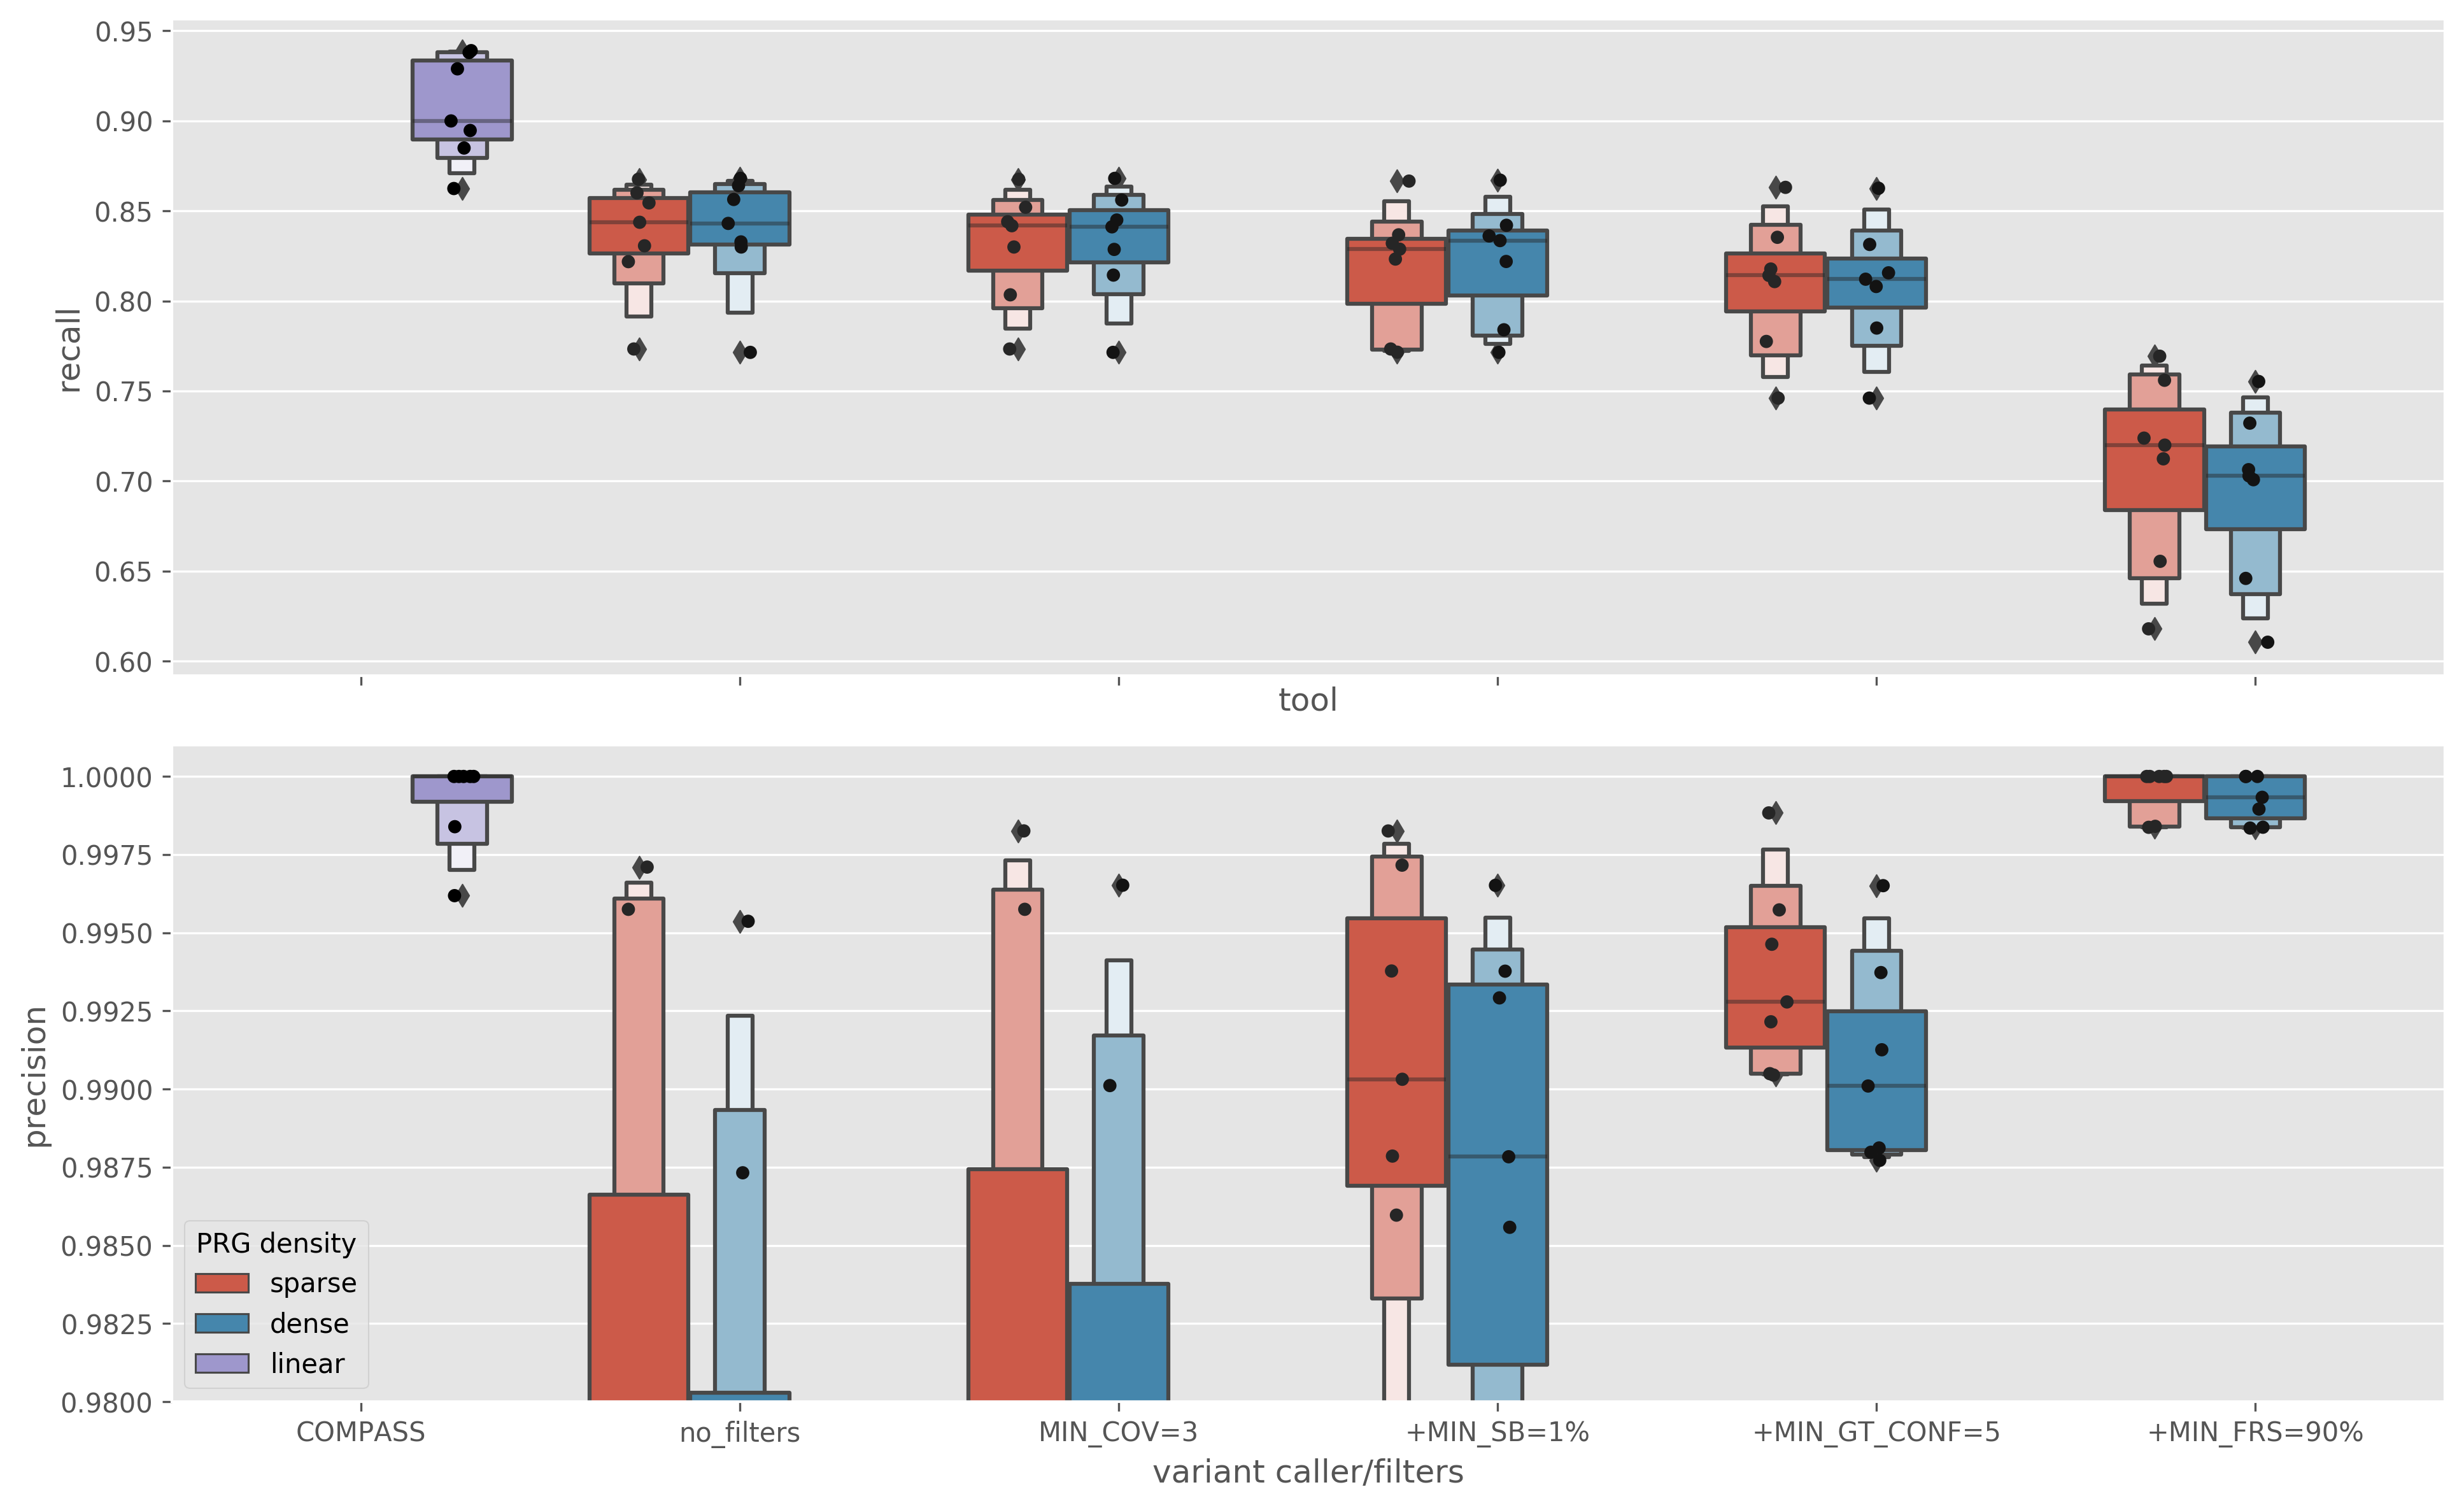

In [10]:
x = "tool"
y = "recall"
df = snps_df
hue = "prg"
# df = snps_df.query("tool not in ['nodenovo', 'none']")
fixed_labels = ["compass", "none"]
order = [*fixed_labels, *[label for label in sorted(df[x].unique()) if label not in fixed_labels]]
fig, axes = plt.subplots(figsize=FIGSIZE, dpi=DPI, nrows=2, sharex=True)
ax = axes.flatten()[0]
sns.boxenplot(x=x, y=y, data=df, ax=ax, k_depth="full", order=order, hue=hue)
sns.stripplot(x=x, y=y, dodge=True, data=df, ax=ax, color="black", order=order, hue=hue)
# ax.set(title=f"{y.capitalize()} for different filters - SNPs only", xlabel="variant caller")
ax.set_ylabel("recall")
# ax.set_xticklabels(["COMPASS", "bcftools", "pandora"])
# ax.set(ylim=(0.70, 0.95))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.legend().remove()
# plt.legend(loc='lower left')
y = "precision"
hue = "prg"
ax = axes.flatten()[1]
sns.boxenplot(x=x, y=y, data=df, ax=ax, k_depth="full", order=order, hue=hue)
sns.stripplot(x=x, y=y, dodge=True, data=df, ax=ax, color="black", order=order, hue=hue)
ax.set(xlabel="variant caller/filters", ylabel="precision")
ax.set_ylim((0.98, 1.001))
xticklabels = ["COMPASS", "no_filters", "MIN_COV=3", "+MIN_SB=1%", "+MIN_GT_CONF=5", "+MIN_FRS=90%"]
ax.set_xticklabels(xticklabels, rotation = 0)
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
leg = ax.legend(handout, lablout, loc="lower left", title="PRG density")
leg.get_texts()[2].set_text("linear")
# plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)
# _ = ax.set_xticklabels(["compass", "bcftools", "#nofilter", "cluster-fix", "K0.9", "no-denovo"])
fig.tight_layout()

In [11]:
df.groupby(["prg", "tool"])["recall"].describe()

count      mean       std       min       25%       50%  \
prg    tool                                                                  
dense  d3            7.0  0.832061  0.031927  0.771435  0.821464  0.841126   
       d3s1          7.0  0.822267  0.033564  0.771435  0.802935  0.833492   
       d3s1g5        7.0  0.808646  0.036427  0.746046  0.796469  0.812055   
       d3s1g5K0.9    7.0  0.693395  0.049602  0.610505  0.673337  0.702868   
       none          7.0  0.837929  0.032819  0.771435  0.831341  0.843030   
none   compass       7.0  0.906790  0.029253  0.862400  0.889754  0.899919   
sparse d3            7.0  0.830267  0.032009  0.773306  0.816658  0.841761   
       d3s1          7.0  0.818858  0.034627  0.771528  0.798272  0.828735   
       d3s1g5        7.0  0.809214  0.038021  0.746046  0.794118  0.814156   
       d3s1g5K0.9    7.0  0.707815  0.053765  0.617939  0.683875  0.719944   
       none          7.0  0.835903  0.031962  0.773306  0.826201  0.843664   

                        75%       max  
prg    tool                            
dense  d3          0.850452  0.868035  
       d3s1        0.839022  0.867028  
       d3s1g5      0.823467  0.862546  
       d3s1g5K0.9  0.719225  0.755266  
       none        0.860161  0.868035  
none   compass     0.933376  0.938951  
sparse d3          0.847976  0.867531  
       d3s1        0.834339  0.866524  
       d3s1g5      0.826505  0.863047  
       d3s1g5K0.9  0.739883  0.769308  
       none        0.857209  0.867531

In [123]:
fig.savefig("/home/michael/Documents/phd/thesis/Chapter2/Figs/pandora-precision-recall-filters-snps.png")

# Indels only

In [124]:
# indel_df = data_for_variants("indels/")

In [125]:
# x = "tool"
# y = "recall"
# hue = "prg"
# fixed_labels = ["none"]
# order = [*fixed_labels, *[label for label in sorted(indel_df[x].unique()) if label not in fixed_labels]]
# fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
# sns.boxenplot(x=x, y=y, data=indel_df, ax=ax, hue=hue, k_depth="full", order=order)
# sns.stripplot(x=x, y=y, dodge=True, data=indel_df, ax=ax, color="black", hue=hue, order=order)
# ax.set(title=f"{y.capitalize()} for different filters - indels only", xlabel="variant caller")
# ax.set_ylabel(RECALL_KEY.replace("_", " "))
# # ax.set(ylim=(0.85, 0.95))
# plt.xticks(rotation=45)
# plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)

In [126]:
# x = "tool"
# y = "precision"
# hue = "prg"
# fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
# sns.boxenplot(x=x, y=y, data=indel_df, ax=ax, hue=hue, k_depth="full", order=order)
# sns.stripplot(x=x, y=y, dodge=True, data=indel_df, ax=ax, color="black", hue=hue, order=order)
# ax.set(title=f"{y.capitalize()} for different filters - indels only", xlabel="variant caller")
# ax.set_ylabel(PRECISION_KEY.replace("_", " "))
# plt.xticks(rotation=45)
# plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)

# All variants

In [12]:
include = {"compass", "none", "d3I20s1g5K0.9", "d3I20s1g5", "d3I20s1", "d3", "d3I20"}
directory = "all/"
json_files = list(Path(directory).rglob("*.json"))

print(len(json_files))

data: List[Tuple[str, str, str, float, float]] = []
columns = ["prg", "sample", "tool", "precision", "recall", "false_negs", "coverage", "f1", "fbeta"]
for p in json_files:
    d = json.loads(p.read_text())
    is_not_pandora = "compass" in p.parts[1] or "bcftools" in p.parts[1]
    prg = "none" if is_not_pandora else p.parts[2]
    sample = p.parts[2] if is_not_pandora else p.parts[3]
    tool = p.parts[1]
    if tool not in include: continue
    covg = coverages[sample]
    if covg < MAX_COVG: continue
    if "FILT" in d["Precision"]:
        precision = float(d["Precision"]["FILT"][PRECISION_KEY])
        recall = float(d["Recall"]["FILT"][RECALL_KEY])
        fns = int(d["Recall"]["FILT"]["FN"]["Count"])
    else:
        precision = float(d["Precision"][PRECISION_KEY])
        recall = float(d["Recall"][RECALL_KEY])
        fns = int(d["Recall"]["FN"]["Count"])
    f1 = f1_score(precision, recall)
    fbeta = f_score(precision, recall, BETA)
    data.append((prg, sample, tool, precision, recall, fns, covg, f1, fbeta))
all_df = pd.DataFrame(data, columns=columns)

434


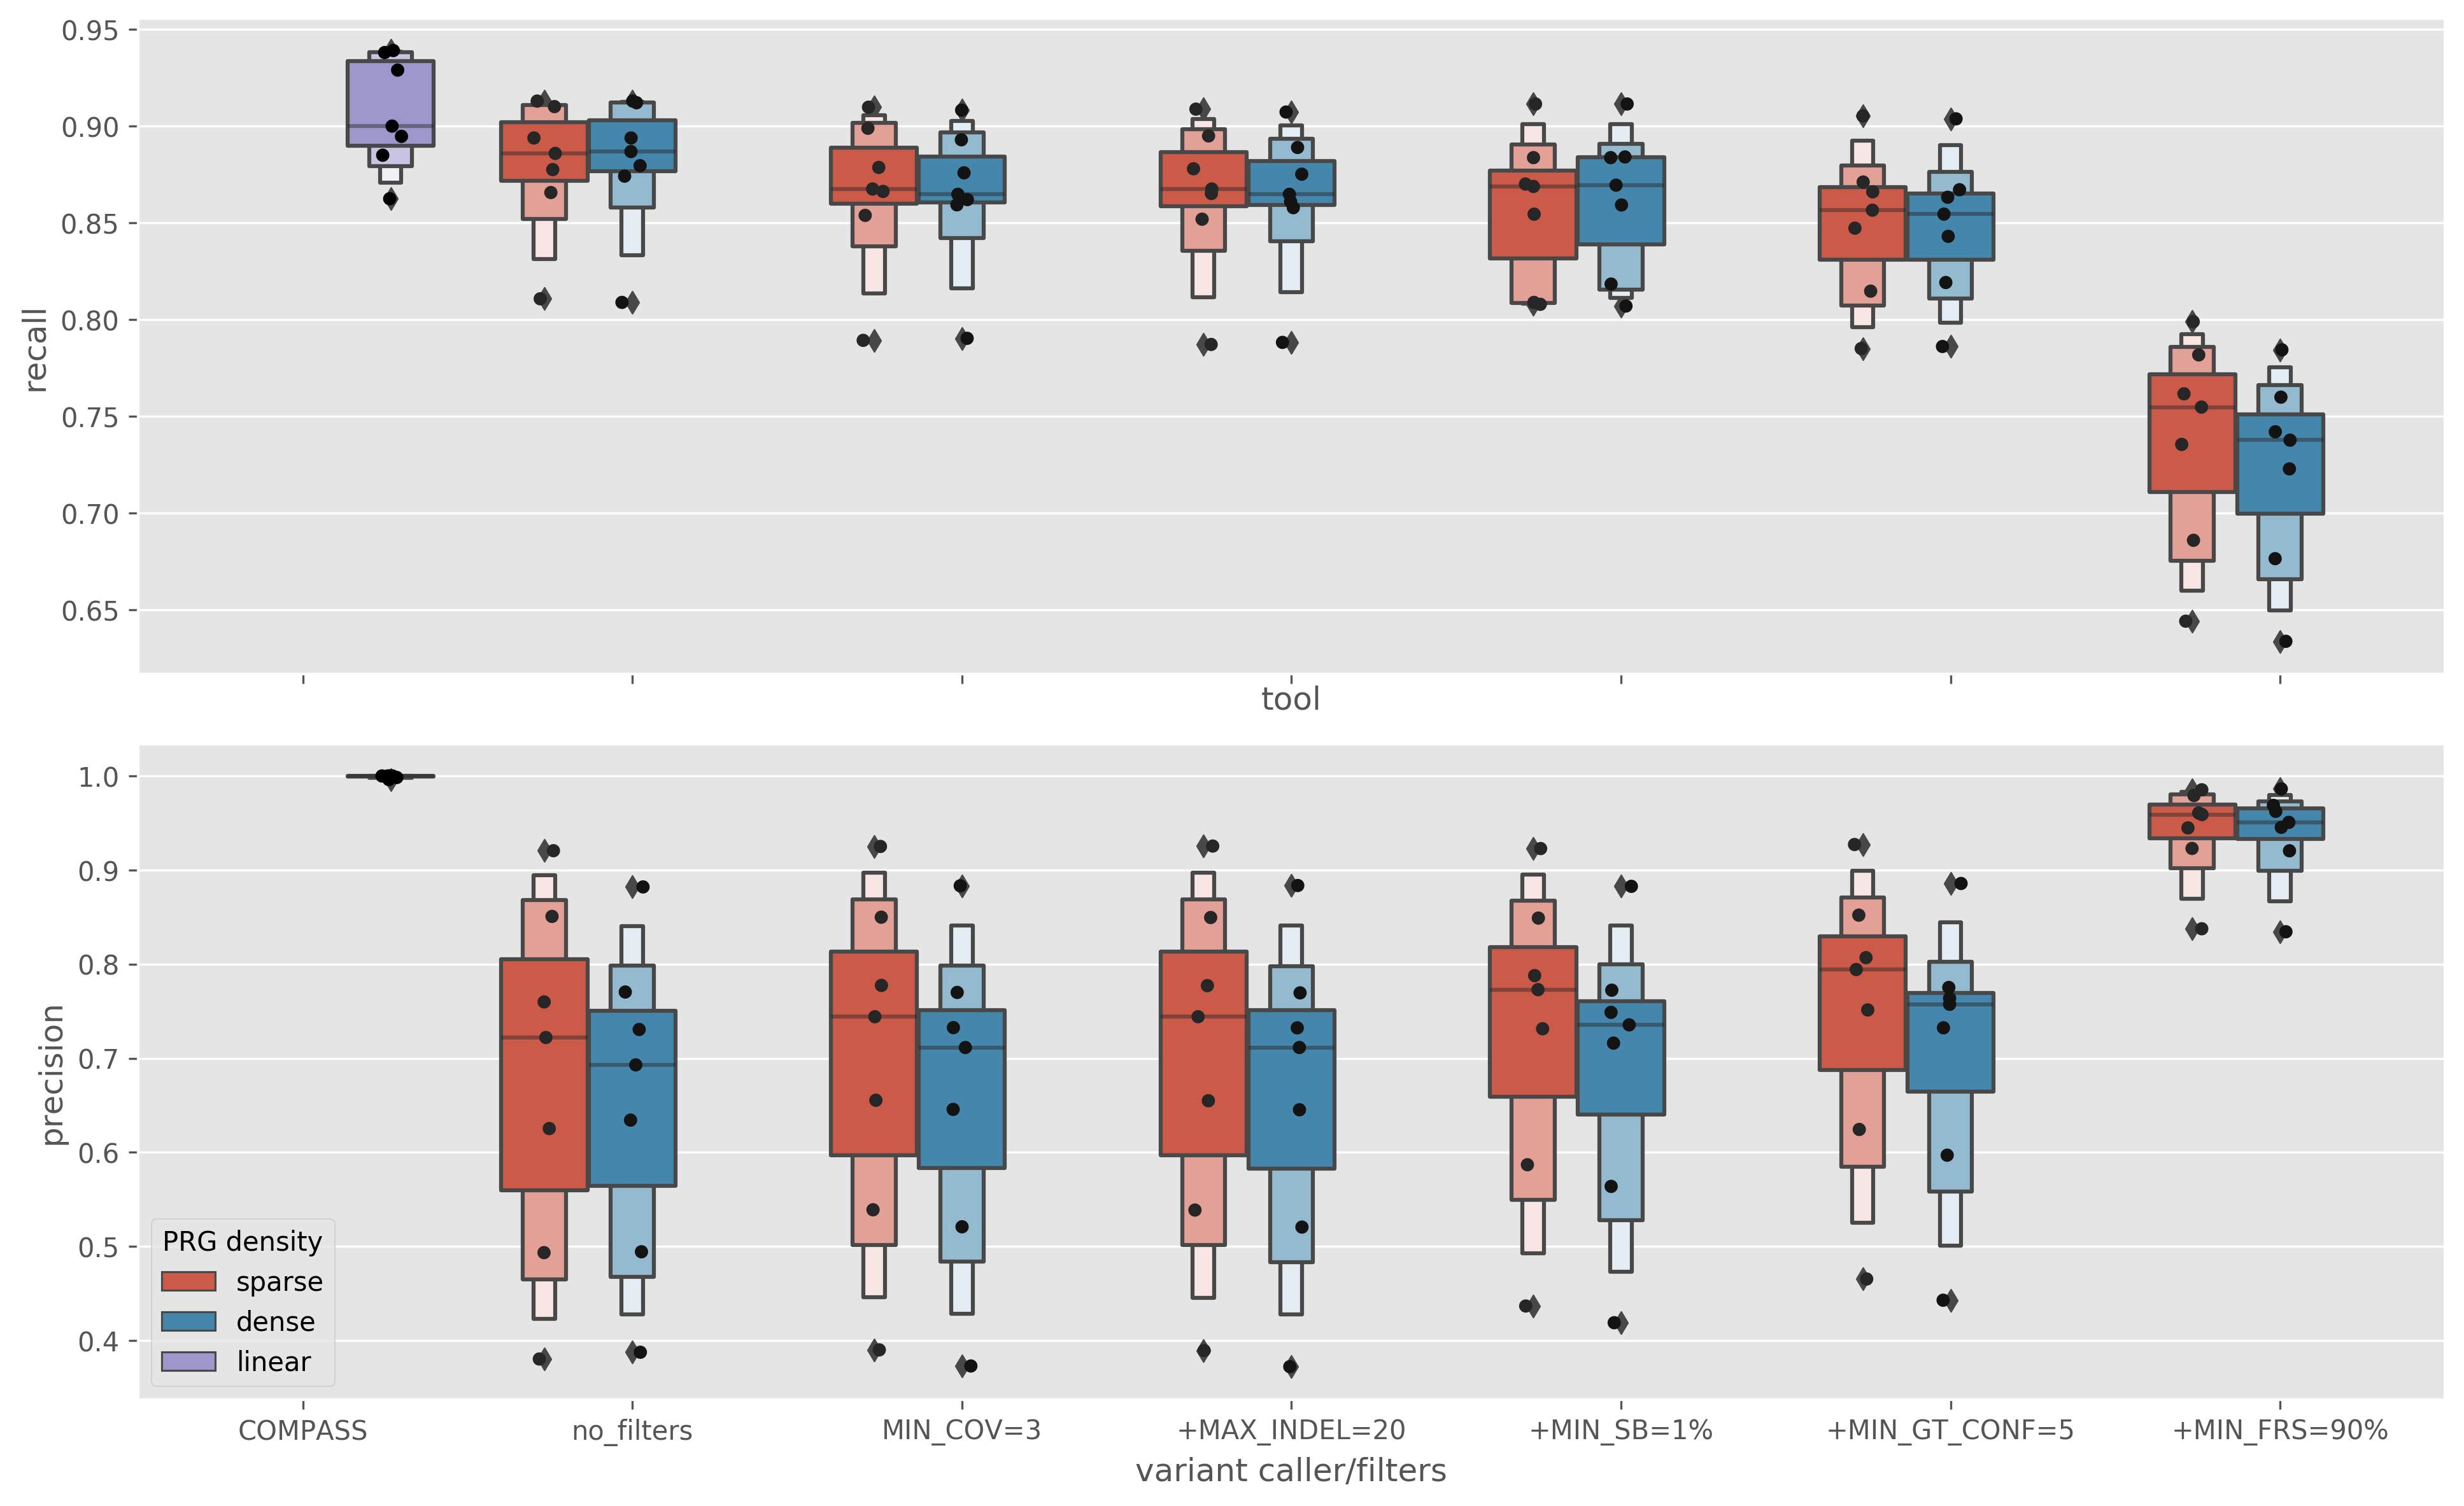

In [13]:
x = "tool"
y = "recall"
df = all_df
hue = "prg"
# df = snps_df.query("tool not in ['nodenovo', 'none']")
fixed_labels = ["compass", "none"]
order = [*fixed_labels, *[label for label in sorted(df[x].unique()) if label not in fixed_labels]]
fig, axes = plt.subplots(figsize=FIGSIZE, dpi=DPI, nrows=2, sharex=True)
ax = axes.flatten()[0]
sns.boxenplot(x=x, y=y, data=df, ax=ax, k_depth="full", order=order, hue=hue)
sns.stripplot(x=x, y=y, dodge=True, data=df, ax=ax, color="black", order=order, hue=hue)
# ax.set(title=f"{y.capitalize()} for different filters - SNPs only", xlabel="variant caller")
ax.set_ylabel("recall")
# ax.set_xticklabels(["COMPASS", "bcftools", "pandora"])
# ax.set(ylim=(0.70, 0.95))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.legend().remove()
# plt.legend(loc='lower left')
y = "precision"
hue = "prg"
ax = axes.flatten()[1]
sns.boxenplot(x=x, y=y, data=df, ax=ax, k_depth="full", order=order, hue=hue)
sns.stripplot(x=x, y=y, dodge=True, data=df, ax=ax, color="black", order=order, hue=hue)
# ax.set(title=f"{y.capitalize()} for different filters - SNPs only", xlabel="variant caller")
ax.set(xlabel="variant caller/filters", ylabel="precision")
# ax.set_ylim((0.996, 1.001))
xticklabels = ["COMPASS", "no_filters", "MIN_COV=3", "+MAX_INDEL=20", "+MIN_SB=1%", "+MIN_GT_CONF=5", "+MIN_FRS=90%"]
ax.set_xticklabels(xticklabels, rotation = 0)
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
leg = ax.legend(handout, lablout, loc="lower left", title="PRG density")
leg.get_texts()[2].set_text("linear")
# plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)
# _ = ax.set_xticklabels(["compass", "bcftools", "#nofilter", "cluster-fix", "K0.9", "no-denovo"])
fig.tight_layout()

In [15]:
all_df.groupby(["prg", "tool"])["precision"].describe()

count      mean       std       min       25%       50%  \
prg    tool                                                                     
dense  d3               7.0  0.662350  0.169212  0.372895  0.583222  0.711387   
       d3I20            7.0  0.662086  0.169462  0.372186  0.582873  0.711387   
       d3I20s1          7.0  0.691140  0.152497  0.418882  0.639934  0.735450   
       d3I20s1g5        7.0  0.707719  0.144279  0.442801  0.664632  0.757299   
       d3I20s1g5K0.9    7.0  0.938336  0.050195  0.834423  0.932935  0.950698   
       none             7.0  0.655990  0.168240  0.387500  0.564254  0.692921   
none   compass          7.0  0.999226  0.001467  0.996188  0.999197  1.000000   
sparse d3               7.0  0.697252  0.184864  0.390017  0.597126  0.744118   
       d3I20            7.0  0.697009  0.185142  0.389313  0.596716  0.744118   
       d3I20s1          7.0  0.726753  0.164836  0.436634  0.659050  0.772896   
       d3I20s1g5        7.0  0.745909  0.154764  0.465336  0.687820  0.794268   
       d3I20s1g5K0.9    7.0  0.941364  0.050269  0.837607  0.933886  0.958979   
       none             7.0  0.678868  0.192693  0.380315  0.559317  0.722000   

                           75%       max  
prg    tool                               
dense  d3             0.751234  0.883259  
       d3I20          0.750861  0.883565  
       d3I20s1        0.760544  0.882690  
       d3I20s1g5      0.769471  0.885728  
       d3I20s1g5K0.9  0.965568  0.986224  
       none           0.750469  0.882066  
none   compass        1.000000  1.000000  
sparse d3             0.813642  0.925097  
       d3I20          0.813352  0.925500  
       d3I20s1        0.818396  0.922847  
       d3I20s1g5      0.829491  0.927136  
       d3I20s1g5K0.9  0.969938  0.985312  
       none           0.805280  0.920569

In [134]:
fig.savefig("/home/michael/Documents/phd/thesis/Chapter2/Figs/pandora-precision-recall-filters-all-variants.png")

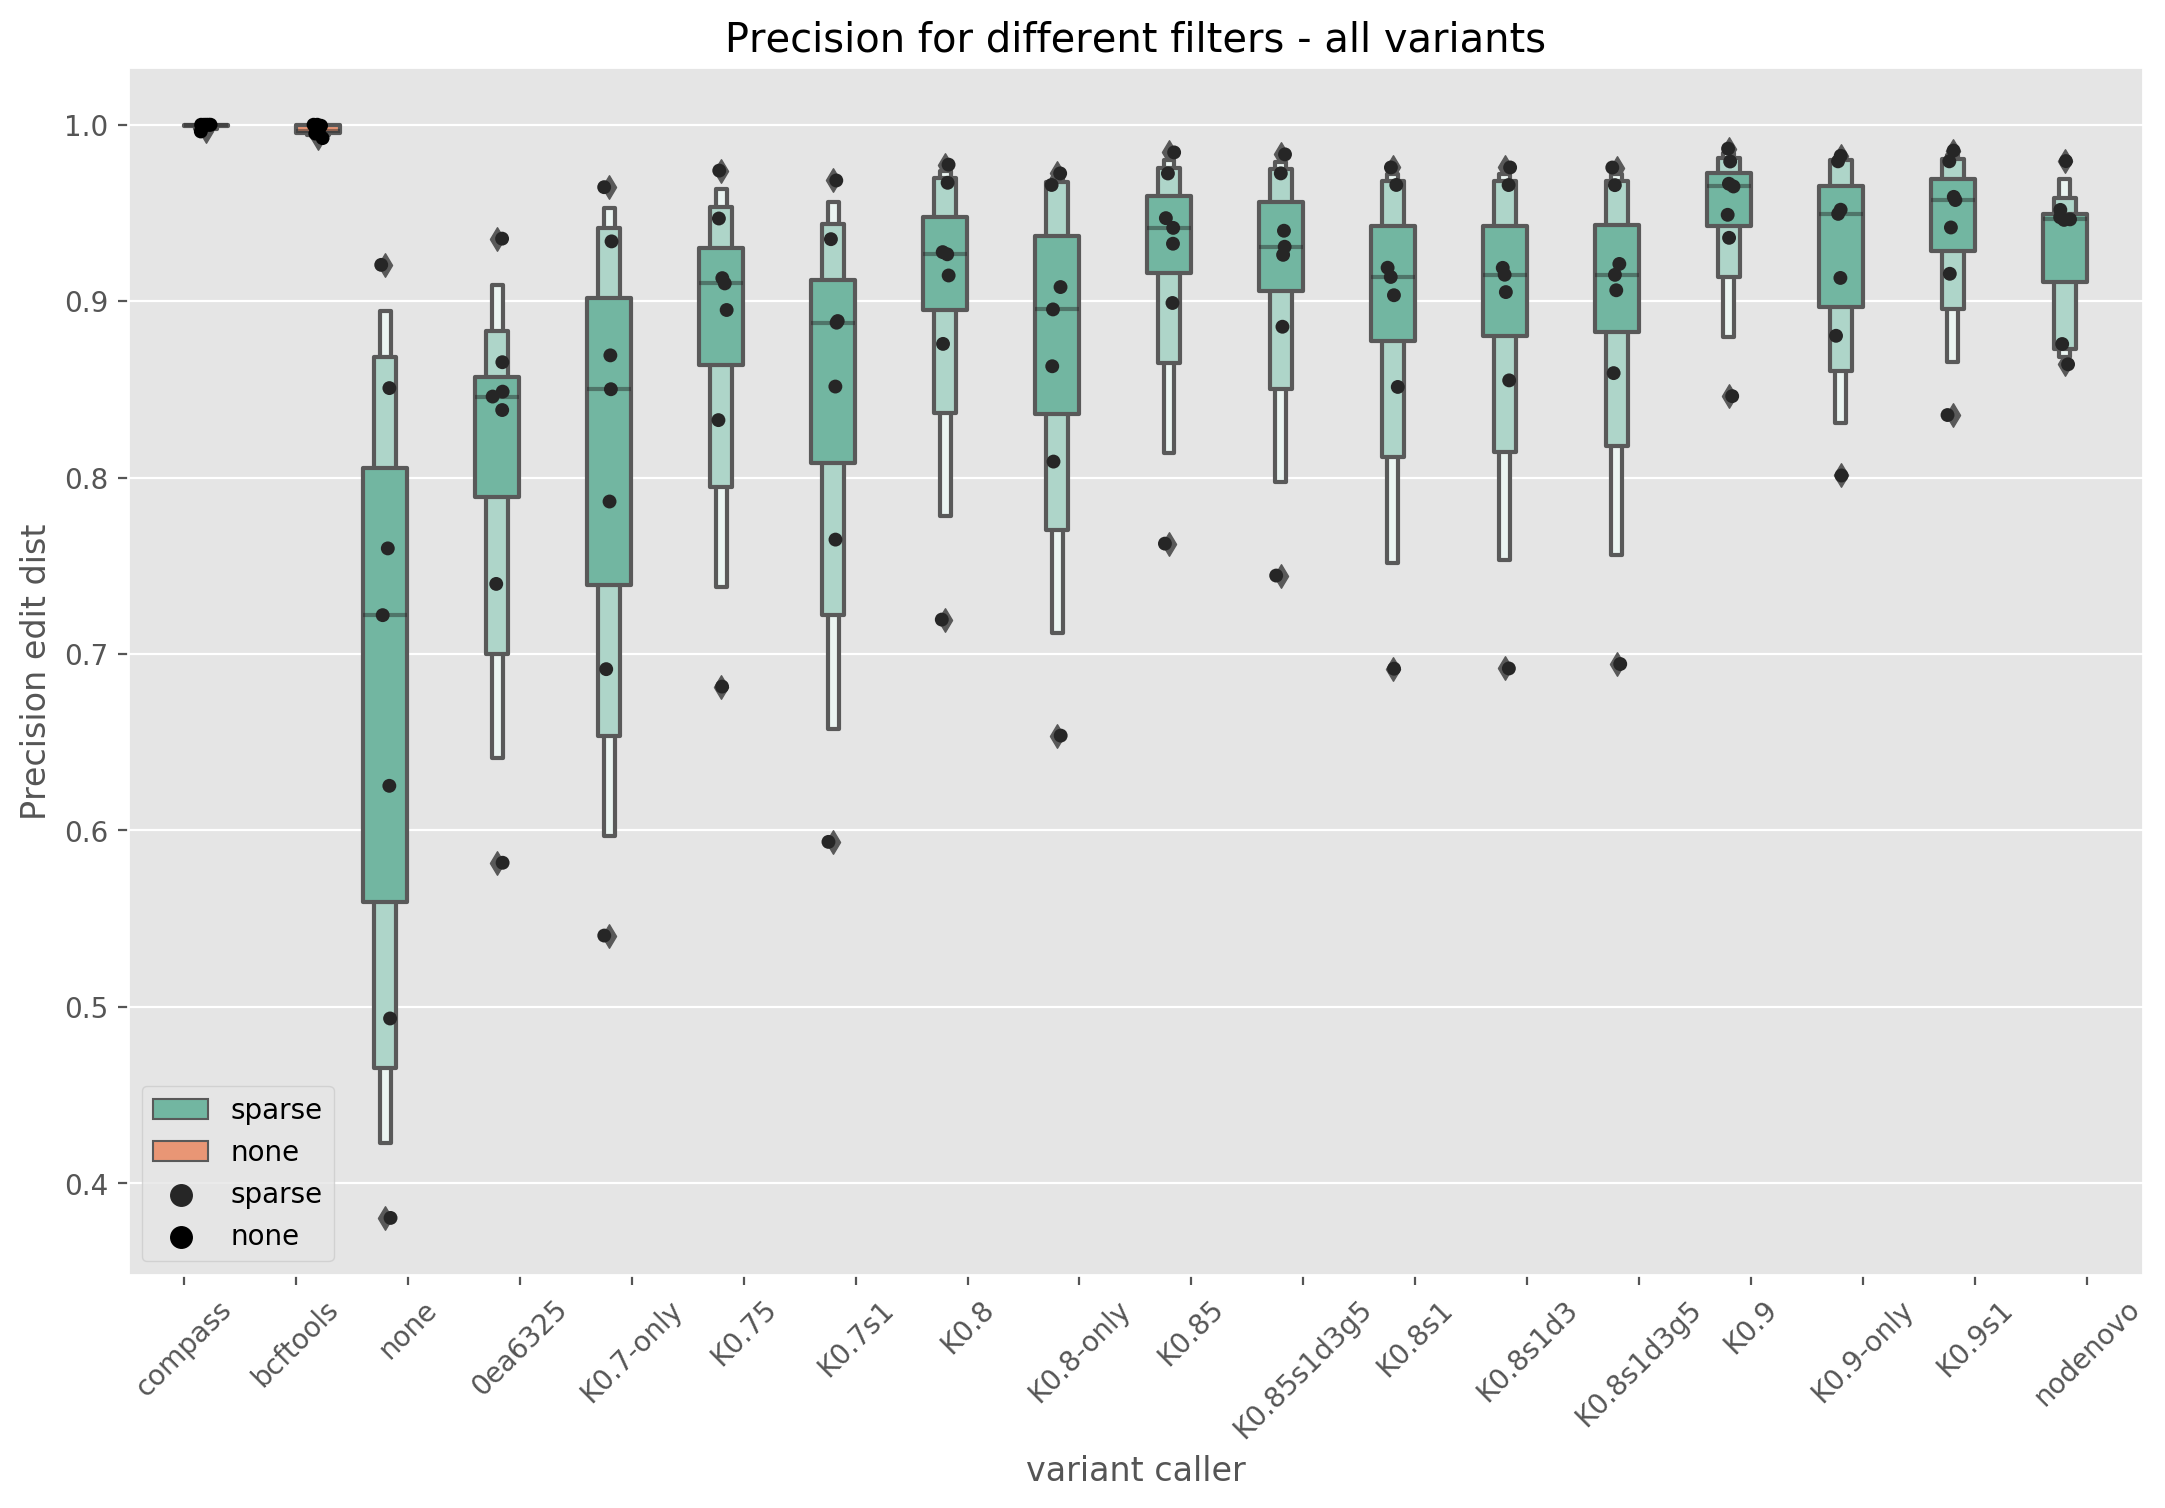

In [18]:
x = "tool"
y = "precision"
hue = "prg"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.boxenplot(x=x, y=y, data=all_df, ax=ax, hue=hue, k_depth="full", order=order)
sns.stripplot(x=x, y=y, dodge=True, data=all_df, ax=ax, color="black", hue=hue, order=order)
ax.set(title=f"{y.capitalize()} for different filters - all variants", xlabel="variant caller")
ax.set_ylabel(PRECISION_KEY.replace("_", " "))
plt.xticks(rotation=45)
plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)

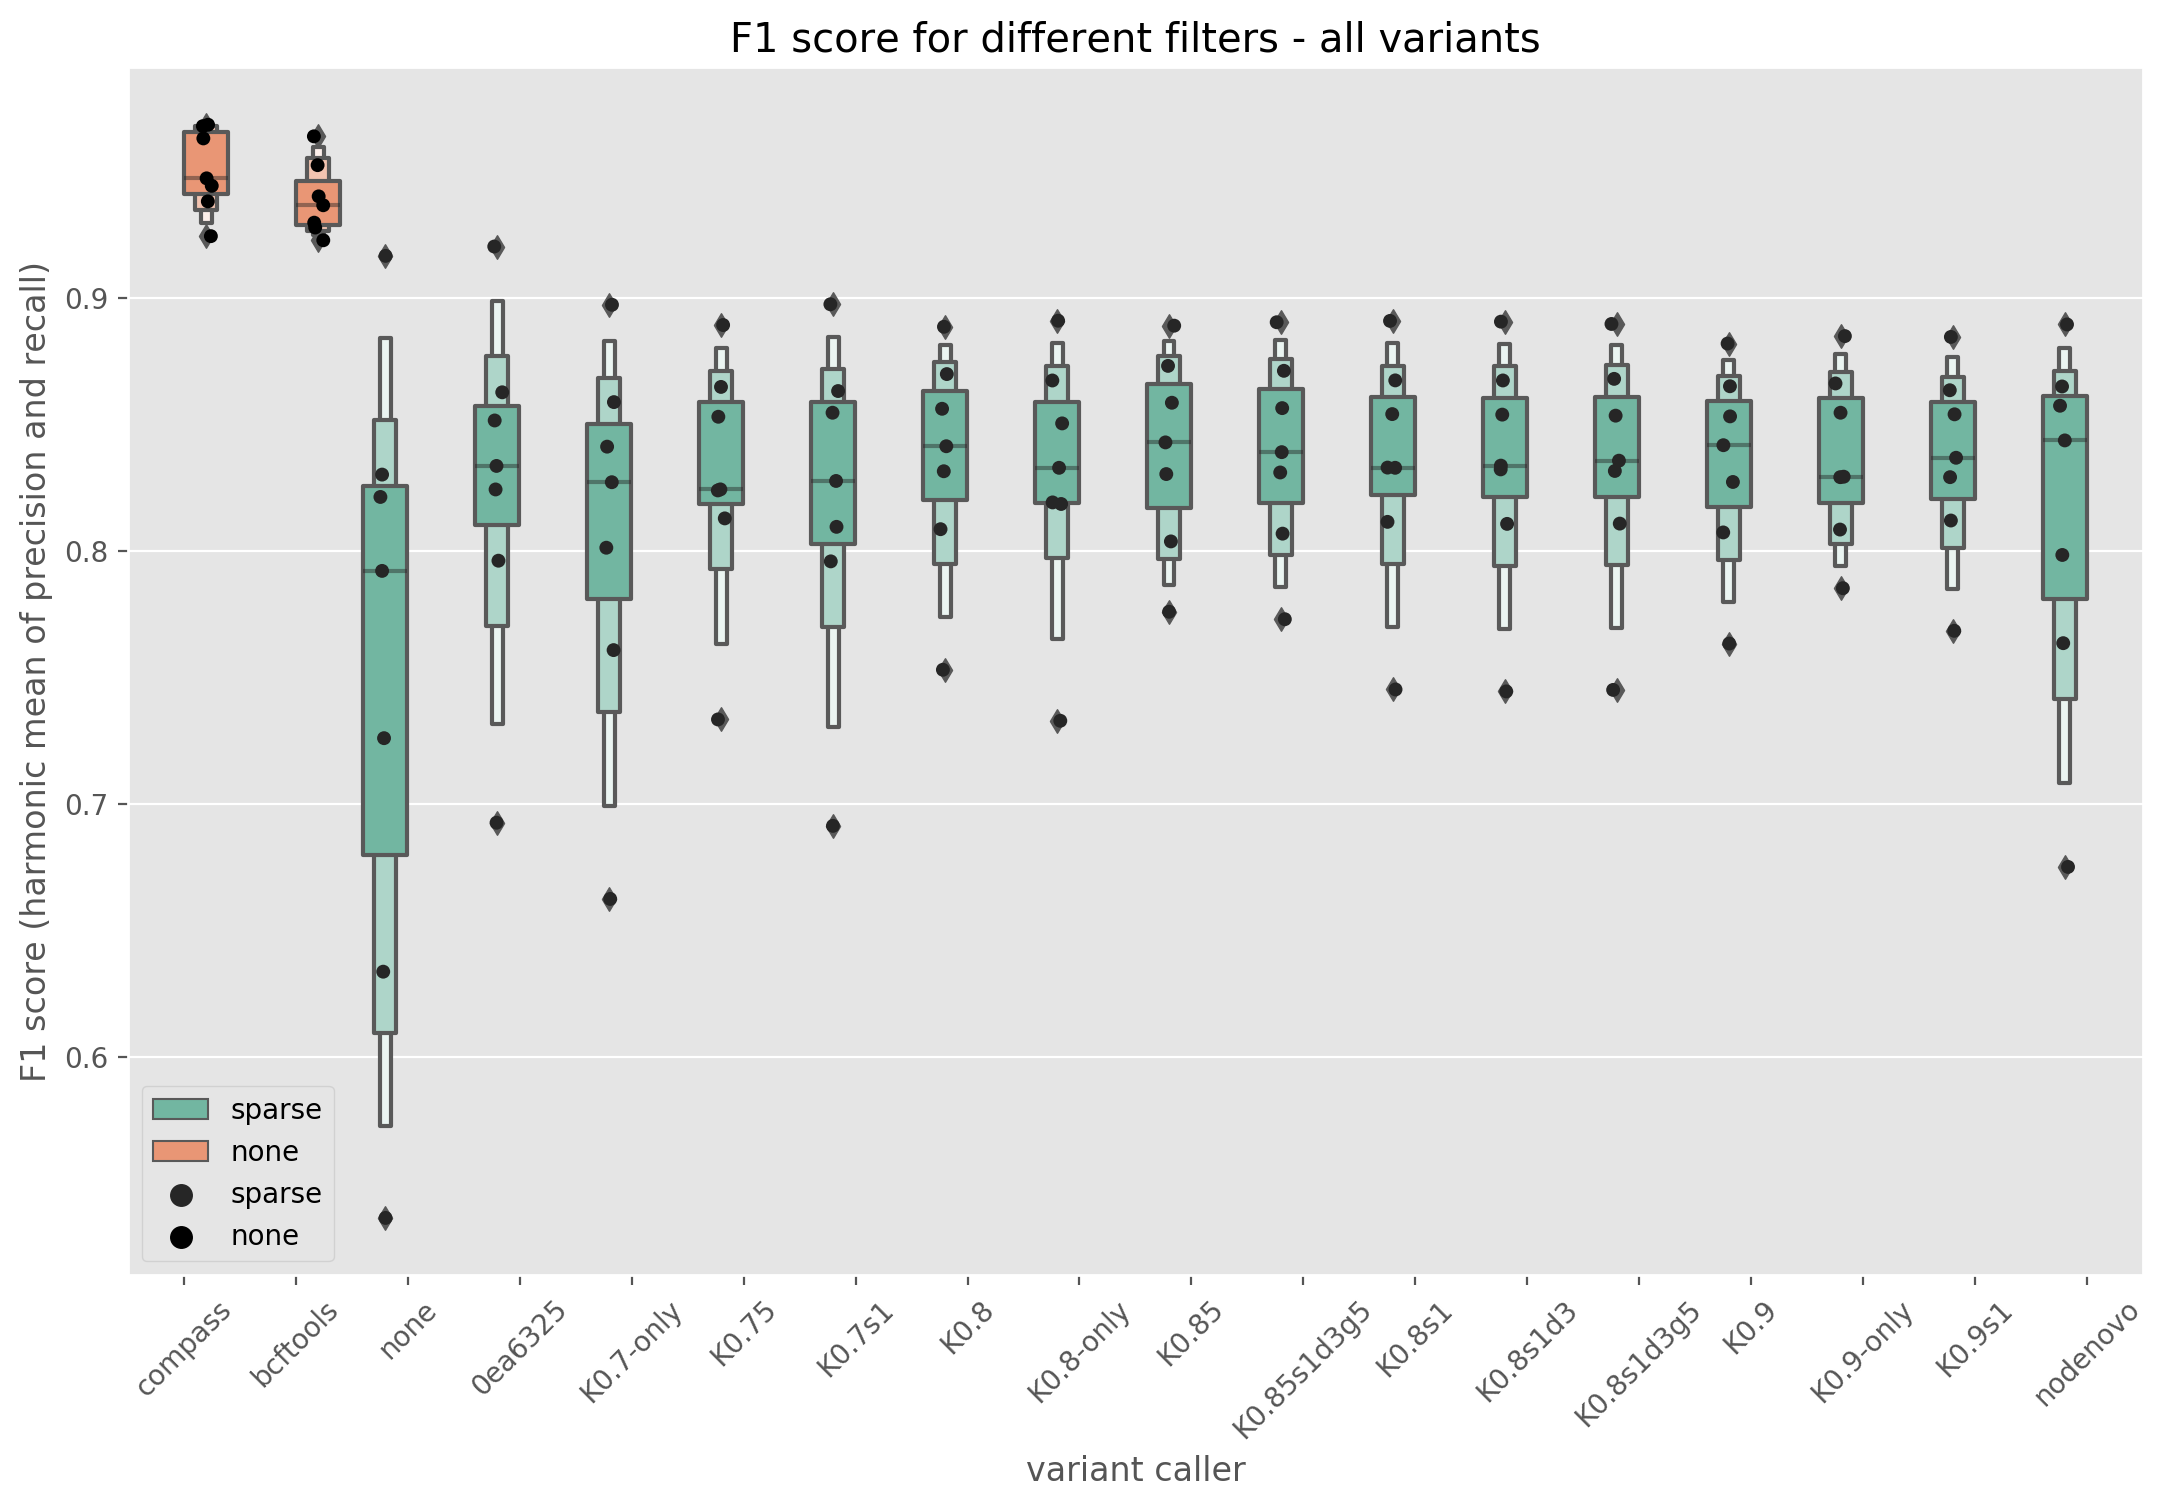

In [19]:
x = "tool"
y = "f1"
hue = "prg"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.boxenplot(x=x, y=y, data=all_df, ax=ax, hue=hue, k_depth="full", order=order)
sns.stripplot(x=x, y=y, dodge=True, data=all_df, ax=ax, color="black", hue=hue, order=order)
ax.set(title=f"{y.capitalize()} score for different filters - all variants", xlabel="variant caller")
ax.set_ylabel("F1 score (harmonic mean of precision and recall)")
# ax.set_ylim((0.90, 1.001))
plt.xticks(rotation=45)
plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)

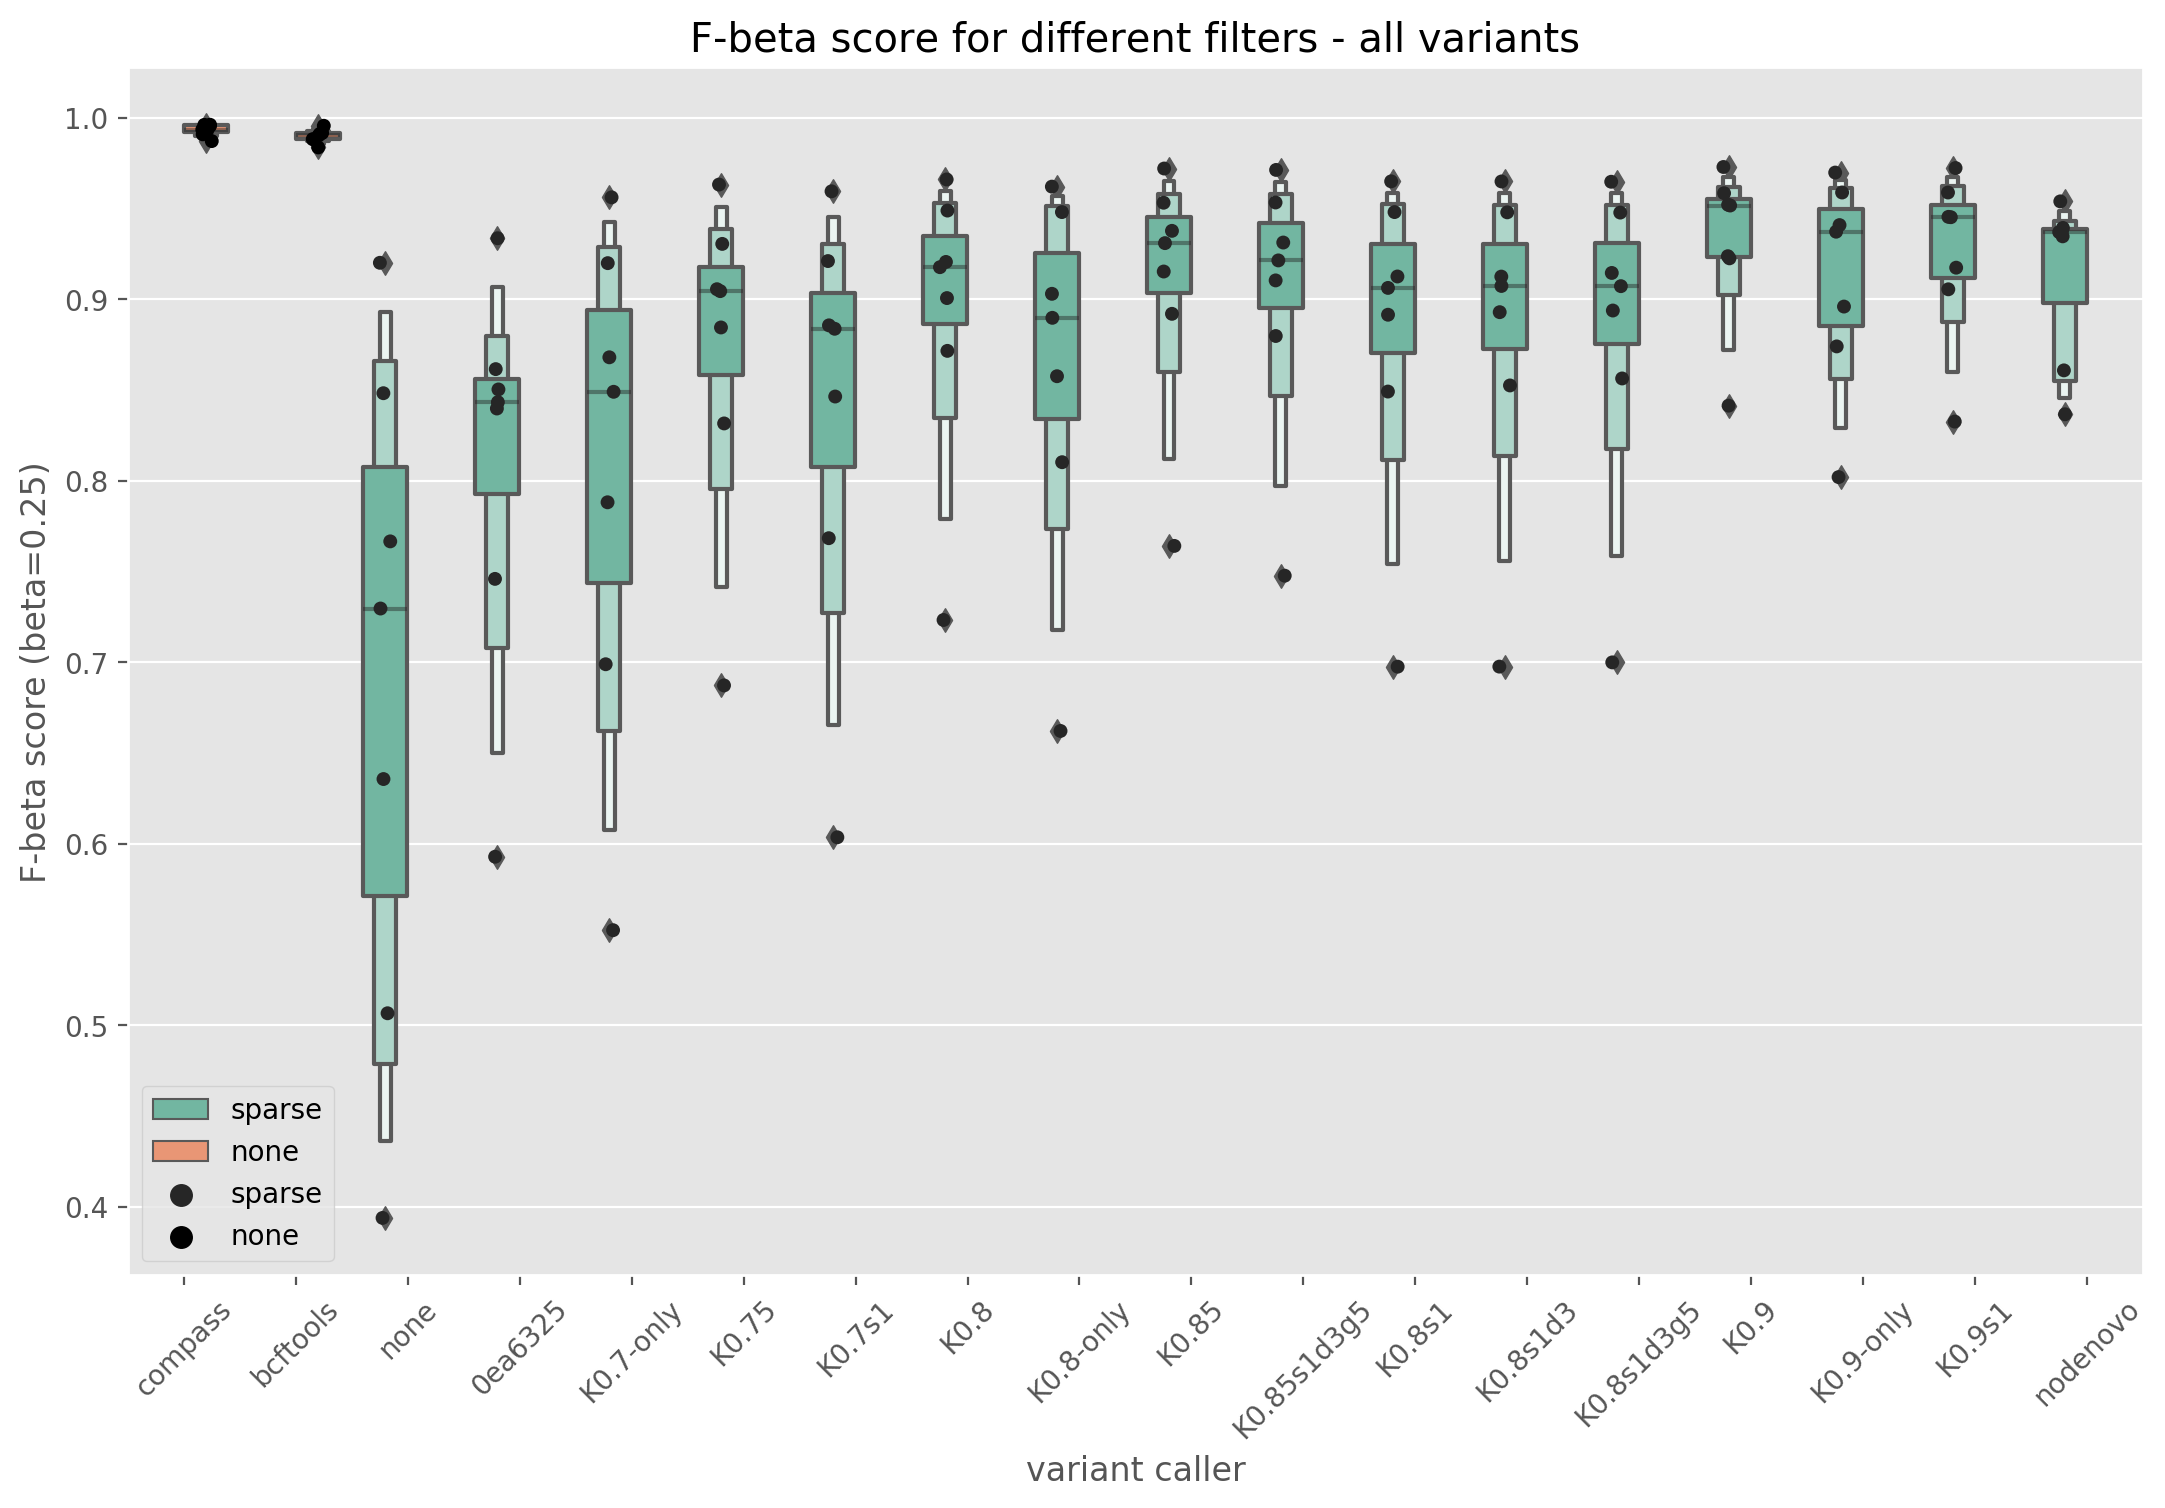

In [20]:
x = "tool"
y = "fbeta"
hue = "prg"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.boxenplot(x=x, y=y, data=all_df, ax=ax, hue=hue, k_depth="full", order=order)
sns.stripplot(x=x, y=y, dodge=True, data=all_df, ax=ax, color="black", hue=hue, order=order)
ax.set(title=f"F-beta score for different filters - all variants", xlabel="variant caller")
ax.set_ylabel(f"F-beta score (beta={BETA})")
# ax.set_ylim((0.70, 1.001))
plt.xticks(rotation=45)
plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)

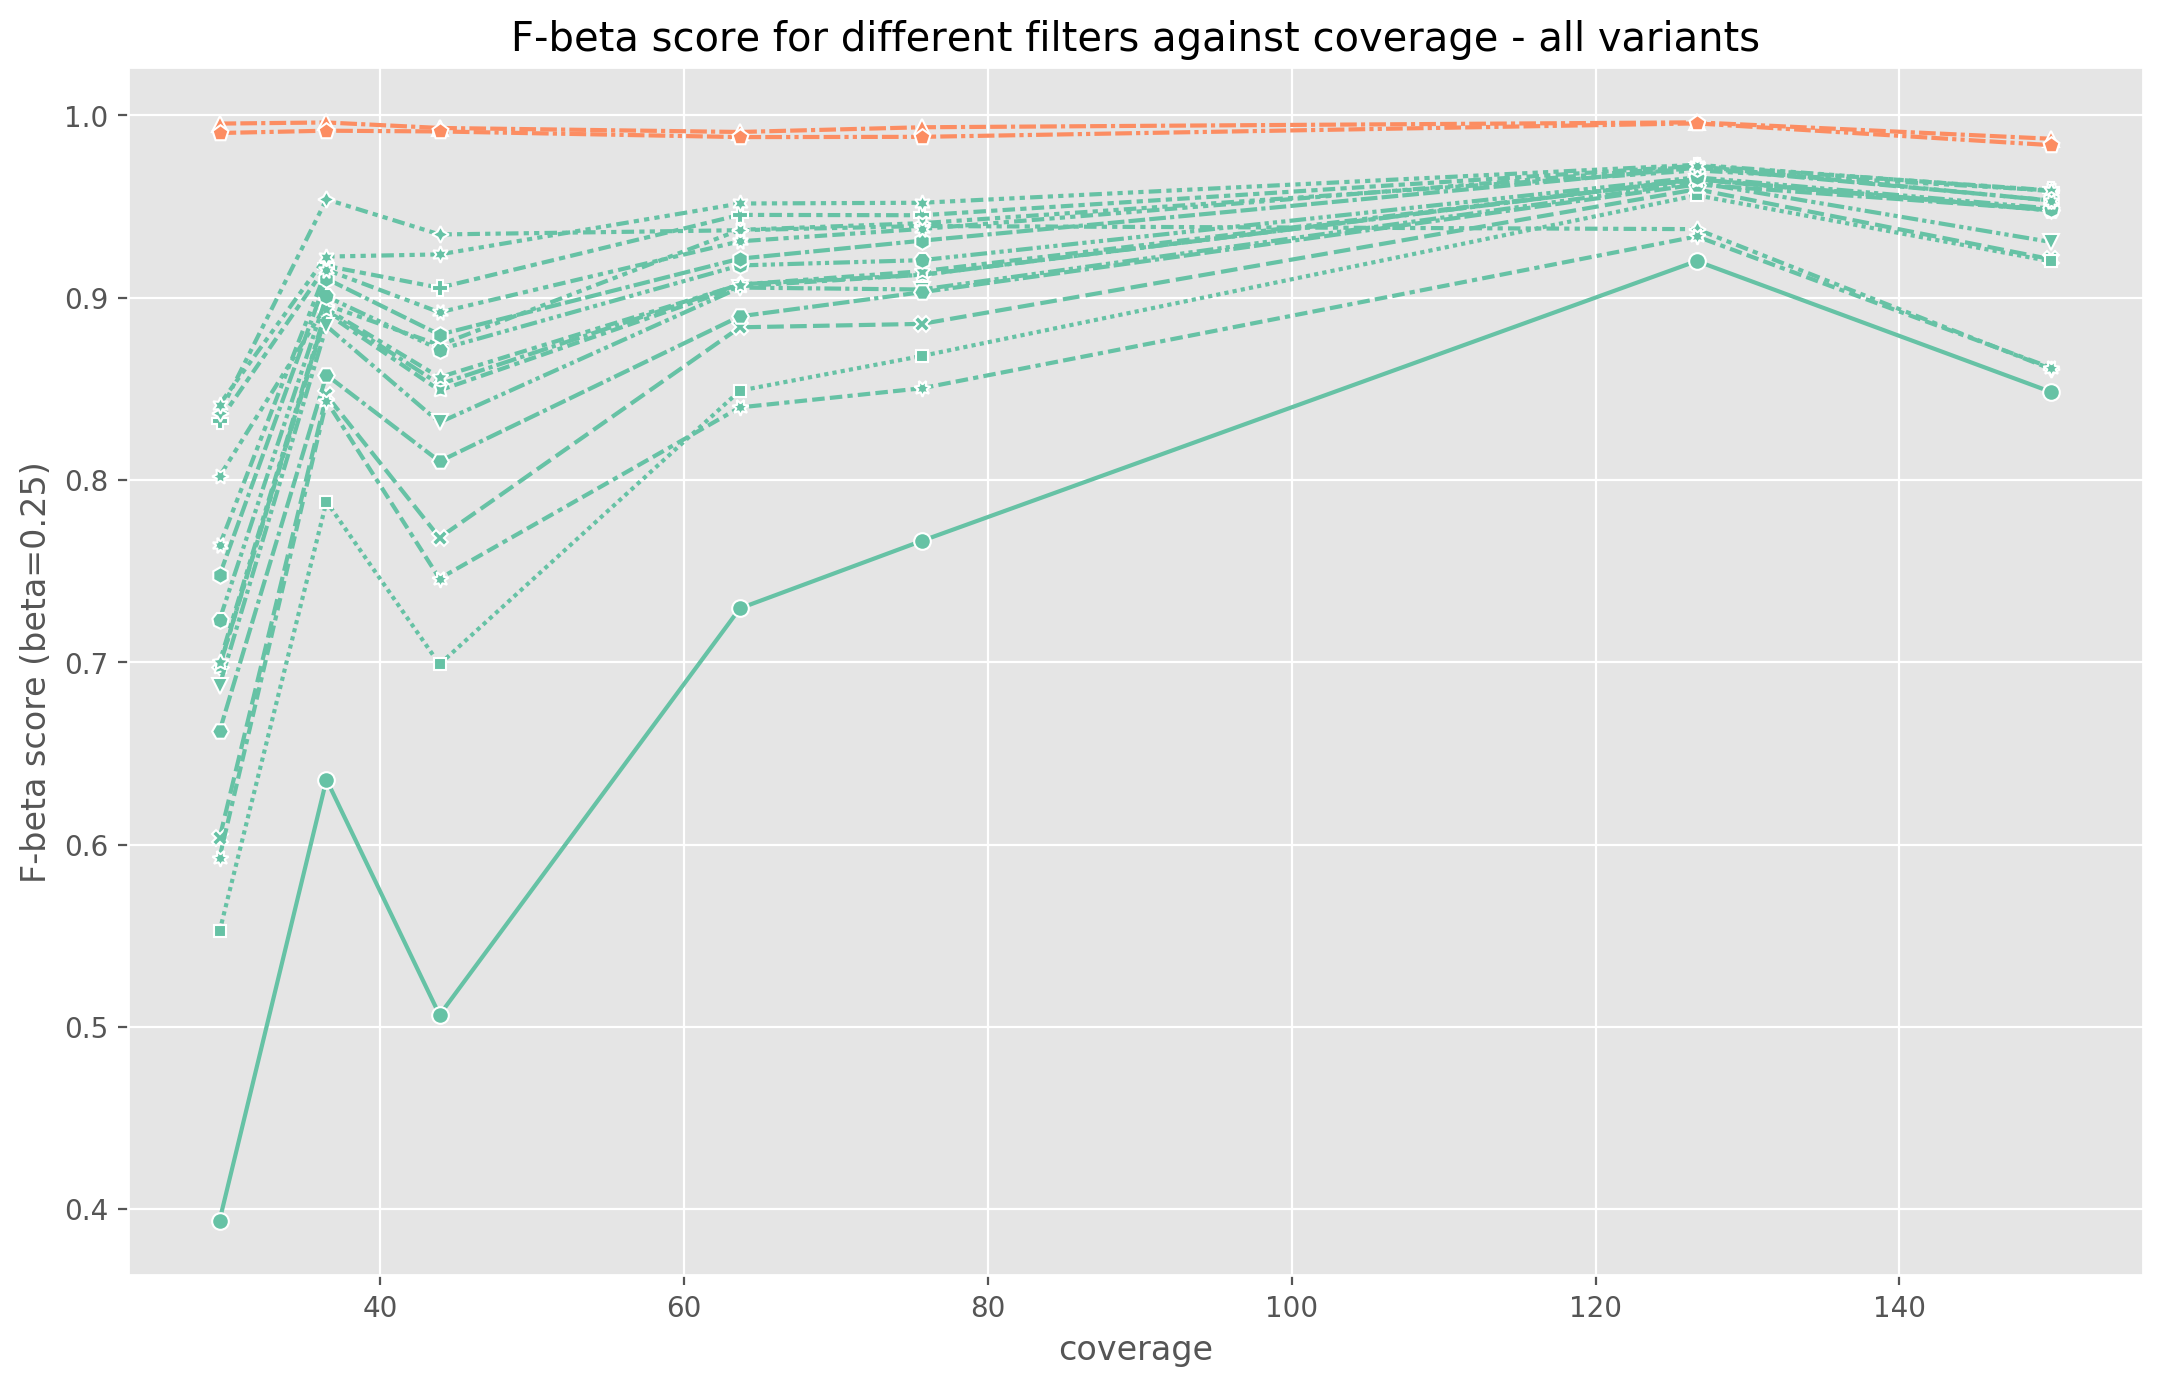

In [21]:
x = "coverage"
y = "fbeta"
hue = "prg"
style="tool"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.lineplot(x=x, y=y, data=all_df, ax=ax, hue=hue, markers=True, style=style)
ax.set(title=f"F-beta score for different filters against coverage - all variants")
ax.set_ylabel(f"F-beta score (beta={BETA})")
# ax.set_ylim((0.90, 1.001))
# plt.xticks(rotation=45)
ax.get_legend().remove()

In [22]:
sparse_summary = all_df.query("prg == 'sparse'").groupby("tool").describe()
metric = "precision"
tool = sparse_summary[metric]["50%"].idxmax()
max_med = sparse_summary[metric]["50%"].max()
print(f"{tool} has the highest median {metric} of {max_med}")
metric = "recall"
tool = sparse_summary[metric]["50%"].idxmax()
max_med = sparse_summary[metric]["50%"].max()
print(f"{tool} has the highest median {metric} of {max_med}")
metric = "f1"
tool = sparse_summary[metric]["50%"].idxmax()
max_med = sparse_summary[metric]["50%"].max()
print(f"{tool} has the highest median {metric} of {max_med}")
metric = "fbeta"
tool = sparse_summary[metric]["50%"].idxmax()
max_med = sparse_summary[metric]["50%"].max()
print(f"{tool} has the highest median {metric} of {max_med}")

K0.9 has the highest median precision of 0.96500921
none has the highest median recall of 0.88582303
nodenovo has the highest median f1 of 0.8437431471973815
K0.9 has the highest median fbeta of 0.9516789381456022
